In [1]:
import pickle
import numpy as np
import keras
import root_numpy
import sklearn.preprocessing
import skimage.measure
import matplotlib.pyplot as plt

Using TensorFlow backend.


Welcome to JupyROOT 6.20/06


In [2]:
with open("zphi1_resnet_v1/train_loss_0.50.p", "rb") as train_loss_file:
    train_loss = pickle.load(train_loss_file)

In [6]:
train_loss

array([0.00565025, 0.00468152, 0.00538408, ..., 0.00443605, 0.00306013,
       0.00286833], dtype=float32)

In [8]:
with open("zphi1_resnet_v1/resnet_minsky_zphi1_0.50_history_v5.p", "rb") as history_file:
    history = pickle.load(history_file)

In [10]:
history.keys()

dict_keys(['val_loss', 'loss'])

Text(0, 0.5, 'MSE Loss')

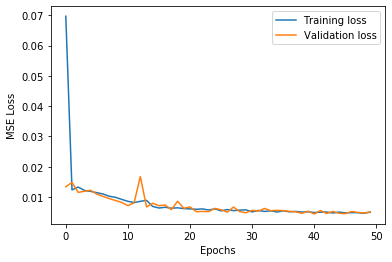

In [45]:
plt.figure(facecolor="white")
plt.plot(history["loss"], label="Training loss")
plt.plot(history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

In [18]:
model = keras.models.load_model("zphi1_resnet_v1/resnet_minsky_zphi1_0.50_v5.hdf5", compile=False)

W0517 14:38:20.659114 140365734958912 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0517 14:38:20.723813 140365734958912 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0517 14:38:21.111952 140365734958912 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2020: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.

W0517 14:38:21.703294 140365734958912 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG

In [19]:
Bchain_zphi1 = root_numpy.root2array("/eos/user/v/vwachira/Pixel2D/ZeroBias_2017B_DataFrame_2D_1.root", "lumisections", "hist_zphi1", "isGoodLumi==1")
Bchain_zphi1 = np.reshape(Bchain_zphi1, (-1, 202, 302))
Bchain_zphi1_2D = np.reshape(Bchain_zphi1, (-1, 202, 302))[:, 1:201, 80:220]
Bchain_zphi1_2D = np.reshape(Bchain_zphi1_2D, (-1, 200*140))
Bchain_zphi1_2D = sklearn.preprocessing.normalize(Bchain_zphi1_2D, norm="max")
Bchain_zphi1_2D = np.reshape(Bchain_zphi1_2D, (-1, 200, 140, 1))
#Bchain_zphi1_2D = skimage.measure.block_reduce(Bchain_zphi1_2D, block_size=(1, 5, 5, 1), func=np.mean)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 140, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 140, 60) 300         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 200, 140, 60) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 200, 140, 60) 300         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

1
33
70
152
178


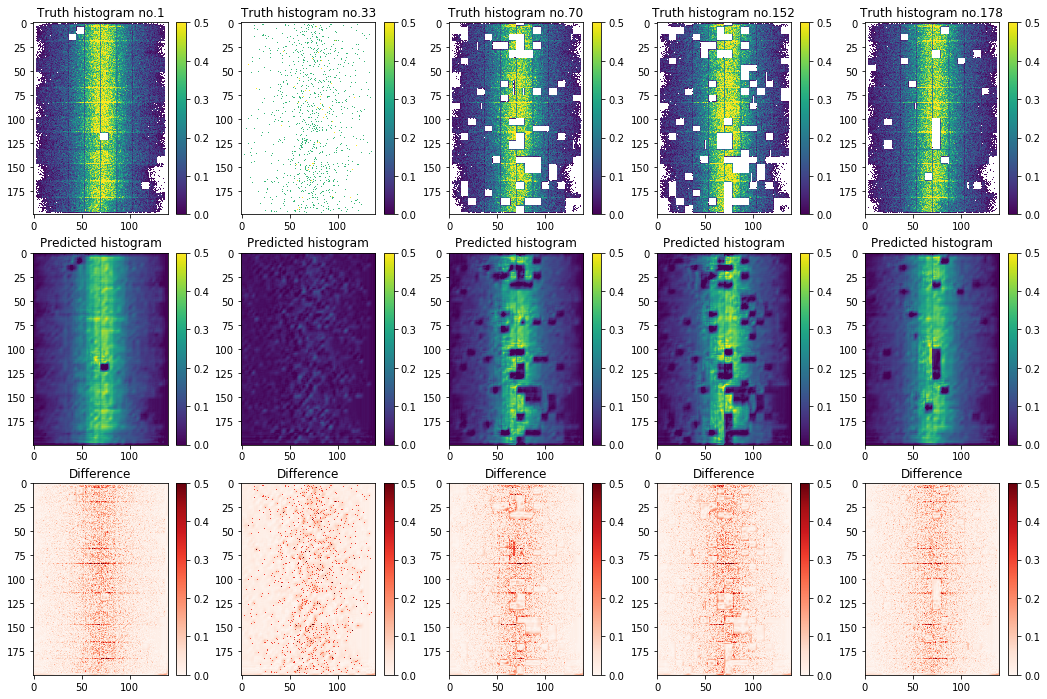

In [24]:
def reshape_and_mask(pred):
    pred = np.reshape(pred, (200, 140))
    pred = np.ma.masked_where(pred == 0, pred)
    return pred

plt.figure(figsize=(18, 12), facecolor="white")
for i, num in enumerate([1, 33, 70, 152, 178]):
    print(num)
    prediction = np.reshape(model.predict(np.reshape(Bchain_zphi1_2D[num], (1, 200, 140, 1))), (200, 140))
    
    plt.subplot(3, 5, i+1)
    plt.imshow(reshape_and_mask(Bchain_zphi1_2D[num]), vmin=0., vmax=0.5)
    plt.title("Truth histogram no.{}".format(num))
    plt.colorbar()
        
    plt.subplot(3, 5, i+6)
    plt.imshow(reshape_and_mask(prediction), vmin=0., vmax=0.5)
    plt.title("Predicted histogram")
    plt.colorbar()
        
    plt.subplot(3, 5, i+11)
    plt.imshow(np.abs(np.reshape(Bchain_zphi1_2D[num], (200, 140))-prediction), vmin=0., vmax=0.5, cmap="Reds")
    plt.title("Difference")
    plt.colorbar()

In [26]:
with open("Bchain_zphi1_2D_mean.p", "rb") as picklefile:
    Bchain_zphi1_2D_mean = pickle.load(picklefile)
with open("Bchain_zphi1_2D_ref_mean.p", "rb") as picklefile:
    Bchain_zphi1_2D_ref_mean = pickle.load(picklefile)

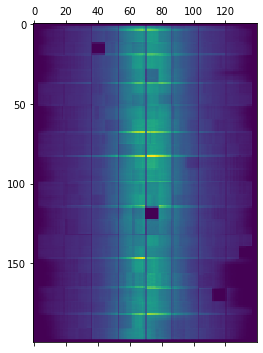

In [27]:
plt.matshow(np.reshape(Bchain_zphi1_2D_mean, (200, 140)))

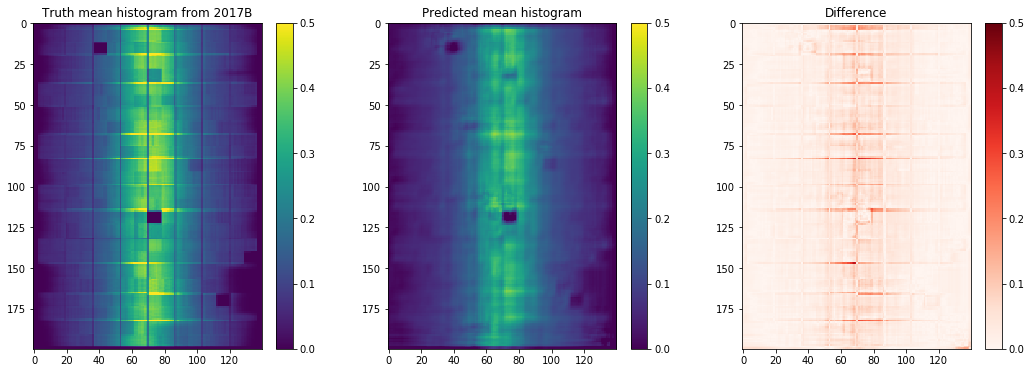

In [31]:
plt.figure(figsize=(18, 6), facecolor="white")
plt.subplot(1, 3, 1)
plt.imshow(np.reshape(Bchain_zphi1_2D_mean, (200, 140)), vmin=0., vmax=0.5)
plt.title("Truth mean histogram from 2017B")
plt.colorbar()

plt.subplot(1, 3, 2)
Bchain_zphi1_2D_mean_out = model.predict(np.reshape(Bchain_zphi1_2D_mean, (1, 200, 140, 1)))
Bchain_zphi1_2D_mean_out = np.reshape(Bchain_zphi1_2D_mean_out, (200, 140))
plt.imshow(Bchain_zphi1_2D_mean_out, vmin=0., vmax=0.5)
plt.title("Predicted mean histogram")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.abs(np.reshape(Bchain_zphi1_2D_mean, (200, 140))-Bchain_zphi1_2D_mean_out), vmin=0., vmax=0.5, cmap="Reds")
plt.title("Difference")
plt.colorbar()

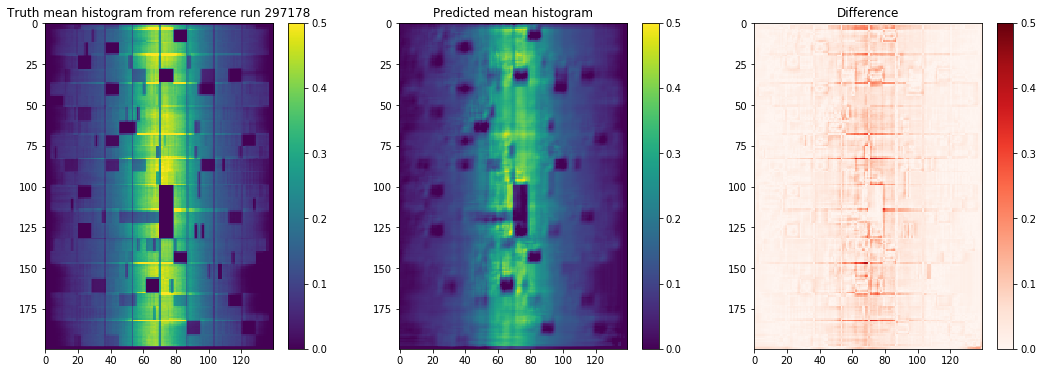

In [33]:
plt.figure(figsize=(18, 6), facecolor="white")
ax1 = plt.subplot(1, 3, 1)
plot_mean_truth = ax1.imshow(np.reshape(Bchain_zphi1_2D_ref_mean, (200, 140)), vmin=0., vmax=0.5)
plt.title("Truth mean histogram from reference run 297178")
plt.colorbar(plot_mean_truth)

plt.subplot(1, 3, 2)
Bchain_zphi1_2D_mean_out = model.predict(np.reshape(Bchain_zphi1_2D_ref_mean, (1, 200, 140, 1)))
Bchain_zphi1_2D_mean_out = np.reshape(Bchain_zphi1_2D_mean_out, (200, 140))
plt.imshow(Bchain_zphi1_2D_mean_out, vmin=0., vmax=0.5)
plt.title("Predicted mean histogram")
plt.colorbar(plot_mean_truth)

plt.subplot(1, 3, 3)
plt.imshow(np.abs(np.reshape(Bchain_zphi1_2D_ref_mean, (200, 140))-Bchain_zphi1_2D_mean_out), vmin=0., vmax=0.5, cmap="Reds")
plt.title("Difference")
plt.colorbar()

In [34]:
Bchain_zphi1_bad = root_numpy.root2array("/eos/user/v/vwachira/Pixel2D/ZeroBias_2017B_DataFrame_2D_1.root", "lumisections", "hist_zphi1", "isGoodLumi==0")
Bchain_zphi1_bad = np.reshape(Bchain_zphi1_bad, (-1, 202, 302))
Bchain_zphi1_bad_2D = np.reshape(Bchain_zphi1_bad, (-1, 202, 302))[:, 1:201, 80:220]
Bchain_zphi1_bad_2D = np.reshape(Bchain_zphi1_bad_2D, (-1, 200*140))
Bchain_zphi1_bad_2D = sklearn.preprocessing.normalize(Bchain_zphi1_bad_2D, norm="max")
Bchain_zphi1_bad_2D = np.reshape(Bchain_zphi1_bad_2D, (-1, 200, 140, 1))

In [35]:
Bchain_zphi1_bad_2D.shape

(20, 200, 140, 1)

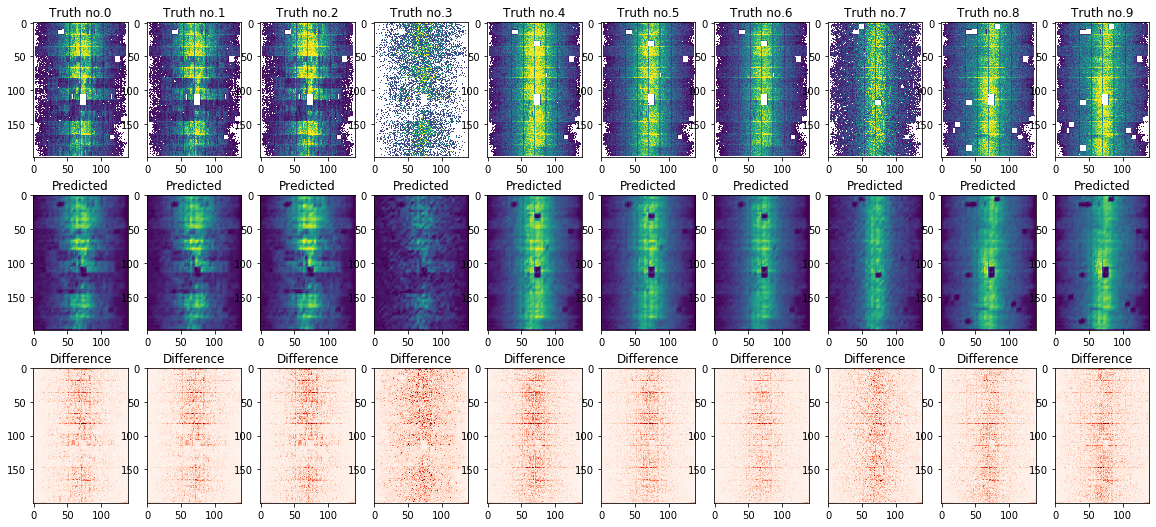

In [36]:
def reshape_and_mask(pred):
    pred = np.reshape(pred, (200, 140))
    pred = np.ma.masked_where(pred == 0, pred)
    return pred

hist_set = list(range(10))

plt.figure(figsize=(20, 9), facecolor="white")
for i, num in enumerate(hist_set):
    #print(num)
    prediction = np.reshape(model.predict(np.reshape(Bchain_zphi1_bad_2D[num], (1, 200, 140, 1))), (200, 140))
    plt.subplot(3, len(hist_set), i+1)
    plt.imshow(reshape_and_mask(Bchain_zphi1_bad_2D[num]), vmin=0., vmax=0.5)
    plt.title("Truth no.{}".format(num))
    plt.subplot(3, len(hist_set), i+1+len(hist_set))
    plt.imshow(reshape_and_mask(prediction), vmin=0., vmax=0.5)
    plt.title("Predicted")
    plt.subplot(3, len(hist_set), i+1+2*len(hist_set))
    plt.imshow(np.abs(np.reshape(Bchain_zphi1_bad_2D[num], (200, 140))-prediction), vmin=0., vmax=0.5, cmap="Reds")
    plt.title("Difference")

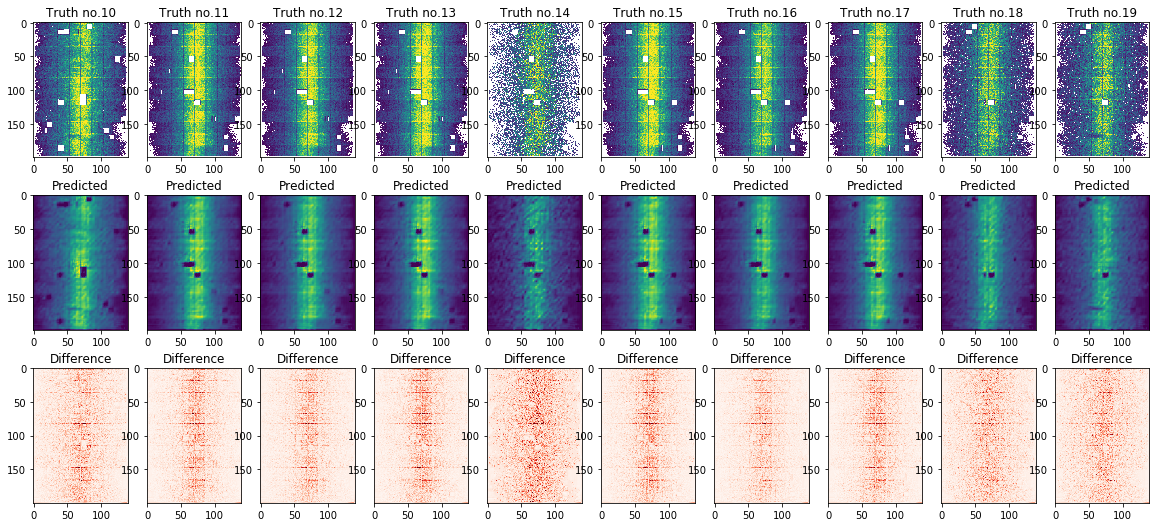

In [38]:
def reshape_and_mask(pred):
    pred = np.reshape(pred, (200, 140))
    pred = np.ma.masked_where(pred == 0, pred)
    return pred

hist_set = list(range(10, 20))

plt.figure(figsize=(20, 9), facecolor="white")
for i, num in enumerate(hist_set):
    #print(num)
    prediction = np.reshape(model.predict(np.reshape(Bchain_zphi1_bad_2D[num], (1, 200, 140, 1))), (200, 140))
    plt.subplot(3, len(hist_set), i+1)
    plt.imshow(reshape_and_mask(Bchain_zphi1_bad_2D[num]), vmin=0., vmax=0.5)
    plt.title("Truth no.{}".format(num))
    plt.subplot(3, len(hist_set), i+1+len(hist_set))
    plt.imshow(reshape_and_mask(prediction), vmin=0., vmax=0.5)
    plt.title("Predicted")
    plt.subplot(3, len(hist_set), i+1+2*len(hist_set))
    plt.imshow(np.abs(np.reshape(Bchain_zphi1_bad_2D[num], (200, 140))-prediction), vmin=0., vmax=0.5, cmap="Reds")
    plt.title("Difference")

In [18]:
model.layers

In [40]:
extractor = keras.Model(inputs=model.inputs, outputs=[model.layers[25].output])

In [41]:
encoded_all = np.reshape(extractor.predict(Bchain_zphi1_2D), (-1, 50, 35))

In [42]:
encoded_all.shape

(544, 50, 35)

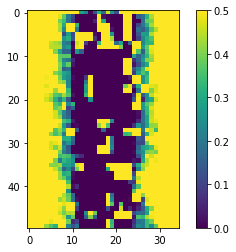

In [33]:
plt.imshow(encoded_all[100], vmin=0., vmax=0.5)
plt.colorbar()

1
33
70
152
178


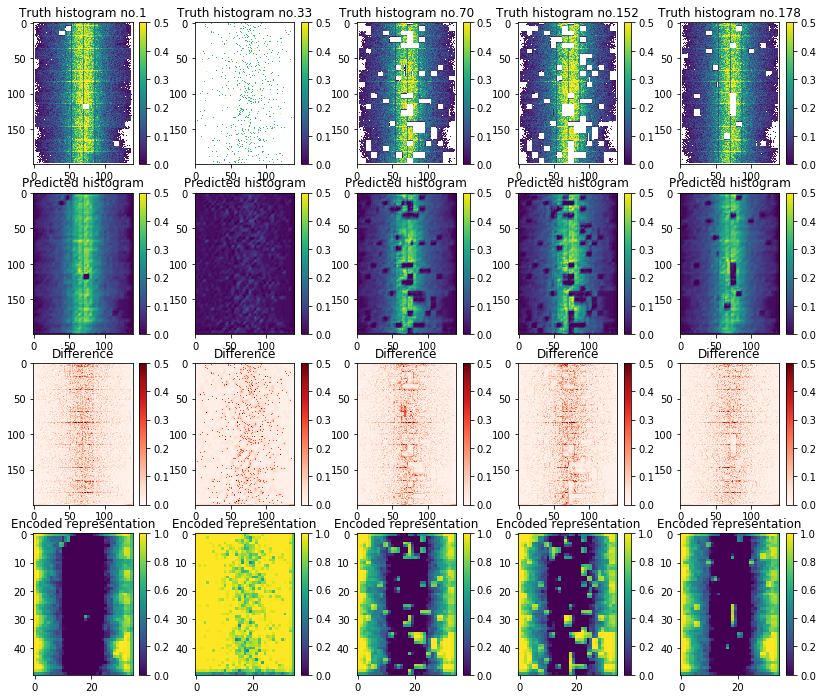

In [44]:
def reshape_and_mask(pred):
    pred = np.reshape(pred, (200, 140))
    pred = np.ma.masked_where(pred == 0, pred)
    return pred

plt.figure(figsize=(14, 12), facecolor="white")
for i, num in enumerate([1, 33, 70, 152, 178]):
    print(num)
    prediction = np.reshape(model.predict(np.reshape(Bchain_zphi1_2D[num], (1, 200, 140, 1))), (200, 140))
    encoded = np.reshape(extractor.predict(np.reshape(Bchain_zphi1_2D[num], (1, 200, 140, 1))), (50, 35))
    
    plt.subplot(4, 5, i+1)
    plt.imshow(reshape_and_mask(Bchain_zphi1_2D[num]), vmin=0., vmax=0.5)
    plt.colorbar()
    plt.title("Truth histogram no.{}".format(num))
    
    plt.subplot(4, 5, i+6)
    plt.imshow(reshape_and_mask(prediction), vmin=0., vmax=0.5)
    plt.colorbar()
    plt.title("Predicted histogram")
    
    plt.subplot(4, 5, i+11)
    plt.imshow(np.abs(np.reshape(Bchain_zphi1_2D[num], (200, 140))-prediction), vmin=0., vmax=0.5, cmap="Reds")
    plt.colorbar()
    plt.title("Difference")
    
    plt.subplot(4, 5, i+1+3*5)
    plt.imshow(encoded, vmin=0., vmax=1.)
    plt.colorbar()
    plt.title("Encoded representation")